In [1]:
!pip install kaggle

In [2]:
import kagglehub
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
#HAM10000
path = kagglehub.dataset_download("annavictoria/speed-dating-experiment")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/speed-dating-experiment


In [4]:
old_path = "/root/.cache/kagglehub/datasets/annavictoria/speed-dating-experiment/versions/1/Speed Dating Data.csv"
new_path = "/root/.cache/kagglehub/datasets/annavictoria/speed-dating-experiment/versions/1/Speed_Dating_Data.csv"

try:
    os.rename(old_path, new_path)
    print("File renamed successfully.")
except FileNotFoundError:
    print(f"The file at {old_path} was not found. No action taken.")
except Exception as e:
    print(f"An error occurred: {e}")


The file at /root/.cache/kagglehub/datasets/annavictoria/speed-dating-experiment/versions/1/Speed Dating Data.csv was not found. No action taken.


In [5]:
import pandas as pd

df = pd.read_csv(
    "/root/.cache/kagglehub/datasets/annavictoria/speed-dating-experiment/versions/1/Speed_Dating_Data.csv",
    encoding="ISO-8859-1"
)
df = df.dropna(subset=['iid', 'pid', 'match'])

df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


# **Data Reformatting**

In [6]:
max_id = df[['iid', 'id', 'partner', 'pid']].max()
max_id

,0
iid,552.0
id,22.0
partner,22.0
pid,552.0


In [7]:
data_for_collaborative_filtering = df[['iid', 'pid', 'match']]
data_for_collaborative_filtering

,iid,pid,match
0,1,11.0,0
1,1,12.0,0
2,1,13.0,1
3,1,14.0,1
4,1,15.0,1
...,...,...,...
8373,552,526.0,0
8374,552,527.0,0
8375,552,528.0,0
8376,552,529.0,0


In [8]:
df[df["pid"] == df["iid"]]


,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3


We conclude that "iid" and "pid" are referring to the same user ID.

---



**looking_for:** goal

**Hobbies/interests:** 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga'

**Values:** 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1'

**Personality:** 'attr3_1', 'sinc3_1', 'intel3_1', 'fun3_1', 'amb3_1'

**interests:** Inverse of 'gender'

**faculty:** 'field_cd'

**age:** age

**gender:** gender




In [9]:
columns = ['iid','pid','wave','goal','sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga',
    'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1','shar1_1','attr3_1', 'sinc3_1', 'intel3_1', 'fun3_1', 'amb3_1', 'gender' , 'field_cd', 'age']

In [10]:
df[columns]

,iid,pid,wave,goal,sports,tvsports,exercise,dining,museums,art,...,amb1_1,shar1_1,attr3_1,sinc3_1,intel3_1,fun3_1,amb3_1,gender,field_cd,age
0,1,11.0,1,2.0,9.0,2.0,8.0,9.0,1.0,1.0,...,15.0,15.0,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0
1,1,12.0,1,2.0,9.0,2.0,8.0,9.0,1.0,1.0,...,15.0,15.0,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0
2,1,13.0,1,2.0,9.0,2.0,8.0,9.0,1.0,1.0,...,15.0,15.0,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0
3,1,14.0,1,2.0,9.0,2.0,8.0,9.0,1.0,1.0,...,15.0,15.0,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0
4,1,15.0,1,2.0,9.0,2.0,8.0,9.0,1.0,1.0,...,15.0,15.0,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,526.0,21,1.0,8.0,2.0,5.0,10.0,10.0,10.0,...,0.0,0.0,8.0,7.0,7.0,6.0,7.0,1,18.0,25.0
8374,552,527.0,21,1.0,8.0,2.0,5.0,10.0,10.0,10.0,...,0.0,0.0,8.0,7.0,7.0,6.0,7.0,1,18.0,25.0
8375,552,528.0,21,1.0,8.0,2.0,5.0,10.0,10.0,10.0,...,0.0,0.0,8.0,7.0,7.0,6.0,7.0,1,18.0,25.0
8376,552,529.0,21,1.0,8.0,2.0,5.0,10.0,10.0,10.0,...,0.0,0.0,8.0,7.0,7.0,6.0,7.0,1,18.0,25.0


In [11]:
df[columns].isnull().sum()


,0
iid,0
pid,0
wave,0
goal,79
sports,79
tvsports,79
exercise,79
dining,79
museums,79
art,79


In [12]:
formatted_df = df[columns].copy()

In [13]:
formatted_df = formatted_df.dropna(subset=columns)

In [14]:
formatted_df.head()

,iid,pid,wave,goal,sports,tvsports,exercise,dining,museums,art,...,amb1_1,shar1_1,attr3_1,sinc3_1,intel3_1,fun3_1,amb3_1,gender,field_cd,age
0,1,11.0,1,2.0,9.0,2.0,8.0,9.0,1.0,1.0,...,15.0,15.0,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0
1,1,12.0,1,2.0,9.0,2.0,8.0,9.0,1.0,1.0,...,15.0,15.0,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0
2,1,13.0,1,2.0,9.0,2.0,8.0,9.0,1.0,1.0,...,15.0,15.0,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0
3,1,14.0,1,2.0,9.0,2.0,8.0,9.0,1.0,1.0,...,15.0,15.0,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0
4,1,15.0,1,2.0,9.0,2.0,8.0,9.0,1.0,1.0,...,15.0,15.0,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0


Replace Keys and Values

Relationship Goal

💗 Long-term Partner

🌷 Long-term but casual OK

😎 Casual but long-term OK

🌟 Casual Fun

🍦New Friends

🔍 Still figuring it out

Hobbies/Interests

🧳 Travel → ✈️

🍿 Movies & Show

📷 Photography

🥂 Grabbing a drink

🎧 Music

⚽️ Sports

💪🏻 Gym

☕️ Cafe

🌱 Nature

📚 Reading

🎮 Video Games

🍽️ Food

🐶 Pets

🎨 Art

🍳 Cooking

🕺🏼 Dancing

Personality

😸 Cheerful

🫡 Reliable

🤸🏻 Active →⚡️

🤗 Caring

🧑🏻‍💻 Introverted

🧑🏻‍💼 Organized → 🗓️

🧑🏻‍🎨 Creative

🤔 Thoughtful →

🙋🏻 Confident → 😎 (มันซ้ำแต่ชอบอันนี้5555 ใช้ซ้ำจะเปนไรมั้ยนะ)

🙈 Playful → 😜

👩🏻‍🚀Ambitious → 🥇

😌 Calm

😗 Chill

Values (What you want in your relationship)

🤝🏻 Honesty and Trust

🧘🏻 Self-Growth

🥳 Having fun

⚖️ Independence and Balance

🗣️ Meaningful Conversation → 💬

🫂 Emotional Support and Empathy

👄 Physical Affection → 🥰


In [15]:
#Hobbies Handling
#None: shopping

new_hobbies_names = {
    "sports": "Sports",
    "tvsports": "Sports",
    "museums": "Art",
    "tv": "Movies & Show",
    "exercise": "Gym",
    "dining": "Food",
    "art": "Art",
    "hiking": "Nature",
    "gaming":"Video Games",
    "clubbing": "Grabbing a drink",
    "reading": "Reading",
    "theater": "Movies & Show",
    "movies": "Movies & Show",
    "concerts": "Dancing",
    "music": "Music",
    "yoga":"Gym"
}
def get_hobbies(row):
    hobbies = set()  # Use set to avoid duplicates
    for col, new_name in new_hobbies_names.items():
        if row[col] > 5:  # Apply condition
            hobbies.add(new_name)  # Add mapped hobby name
    return ', '.join(sorted(hobbies))  # Convert set to sorted string

# Apply function to DataFrame
formatted_df["hobbies"] = formatted_df.apply(get_hobbies, axis=1)

In [16]:
formatted_df.head()

,iid,pid,wave,goal,sports,tvsports,exercise,dining,museums,art,...,shar1_1,attr3_1,sinc3_1,intel3_1,fun3_1,amb3_1,gender,field_cd,age,hobbies
0,1,11.0,1,2.0,9.0,2.0,8.0,9.0,1.0,1.0,...,15.0,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read..."
1,1,12.0,1,2.0,9.0,2.0,8.0,9.0,1.0,1.0,...,15.0,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read..."
2,1,13.0,1,2.0,9.0,2.0,8.0,9.0,1.0,1.0,...,15.0,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read..."
3,1,14.0,1,2.0,9.0,2.0,8.0,9.0,1.0,1.0,...,15.0,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read..."
4,1,15.0,1,2.0,9.0,2.0,8.0,9.0,1.0,1.0,...,15.0,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read..."


In [17]:
formatted_df = formatted_df.drop(columns=new_hobbies_names.keys())
formatted_df = formatted_df.drop(columns=["shopping"])

In [18]:
#Relationship Goal Handling
goal_mapping = {
    1: "Casual Fun",
    2: "New Friends",
    3: "Long-term/Casual",
    4: "Long-term Partner",
    5: "To say I did it",
    6: "Still figuring it out"
}
formatted_df['goal'] = formatted_df['goal'].replace(goal_mapping)


In [19]:
#Values Handling
new_column_names = {
    "attr1_1": "Physical Affection",
    "sinc1_1": "Emotional Support and Empathy",
    "intel1_1": "Meaningful Conversation",
    "fun1_1": "Having fun",
    "amb1_1": "Self-Growth",
    "shar1_1": "Meaningful Conversation2"
}
formatted_df.rename(columns=new_column_names, inplace=True)


In [20]:
formatted_df.head()

,iid,pid,wave,goal,Physical Affection,Emotional Support and Empathy,Meaningful Conversation,Having fun,Self-Growth,Meaningful Conversation2,attr3_1,sinc3_1,intel3_1,fun3_1,amb3_1,gender,field_cd,age,hobbies
0,1,11.0,1,New Friends,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read..."
1,1,12.0,1,New Friends,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read..."
2,1,13.0,1,New Friends,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read..."
3,1,14.0,1,New Friends,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read..."
4,1,15.0,1,New Friends,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read..."


In [21]:
attribute_columns = ['Physical Affection', 'Emotional Support and Empathy',
                         'Meaningful Conversation', 'Having fun', 'Self-Growth',
                         'Meaningful Conversation2']

In [22]:
# Define the function to filter attributes based on wave conditions
def filter_attributes(row, threshold_1_5_10_21=15, threshold_6_9=5):
    wave = row['wave']

    # Determine the threshold based on wave value
    threshold = threshold_1_5_10_21 if (1 <= wave <= 5 or 10 <= wave <= 21) else threshold_6_9

    # Filter attributes that exceed the threshold
    selected_attrs = [col for col in attribute_columns if row[col] > threshold]

    # Handling 'Meaningful Conversation' and 'Meaningful Conversation2'
    if 'Meaningful Conversation' in selected_attrs and 'Meaningful Conversation2' in selected_attrs:
        selected_attrs.remove('Meaningful Conversation2')  # Keep only 'Meaningful Conversation'
    elif 'Meaningful Conversation2' in selected_attrs:
        selected_attrs[selected_attrs.index('Meaningful Conversation2')] = 'Meaningful Conversation'  # Rename

    return ', '.join(selected_attrs)  # Join selected attributes into a string

# Apply the function to create the 'values' column
formatted_df['values'] = formatted_df.apply(filter_attributes, axis=1)
formatted_df = formatted_df.drop(columns=attribute_columns)

# Display the updated DataFrame
print(formatted_df[['wave', 'values']].head())  # Showing only wave and values for brevity


   wave                                             values
0     1  Emotional Support and Empathy, Meaningful Conv...
1     1  Emotional Support and Empathy, Meaningful Conv...
2     1  Emotional Support and Empathy, Meaningful Conv...
3     1  Emotional Support and Empathy, Meaningful Conv...
4     1  Emotional Support and Empathy, Meaningful Conv...


In [23]:
formatted_df.head()

,iid,pid,wave,goal,attr3_1,sinc3_1,intel3_1,fun3_1,amb3_1,gender,field_cd,age,hobbies,values
0,1,11.0,1,New Friends,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read...","Emotional Support and Empathy, Meaningful Conv..."
1,1,12.0,1,New Friends,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read...","Emotional Support and Empathy, Meaningful Conv..."
2,1,13.0,1,New Friends,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read...","Emotional Support and Empathy, Meaningful Conv..."
3,1,14.0,1,New Friends,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read...","Emotional Support and Empathy, Meaningful Conv..."
4,1,15.0,1,New Friends,6.0,8.0,8.0,8.0,7.0,0,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read...","Emotional Support and Empathy, Meaningful Conv..."


In [24]:
#Personality Handling
new_column_personality = {
    "attr3_1": "Confident",
    "sinc3_1": "Caring",
    "intel3_1": "Reliable, Organized, Thoughtful",
    "fun3_1": "Cheerful, Active, Playful",
    "amb3_1": "Ambitious",
}
formatted_df.rename(columns=new_column_personality, inplace=True)


In [25]:
formatted_df.columns

Index(['iid', 'pid', 'wave', 'goal', 'Confident', 'Caring',
       'Reliable, Organized, Thoughtful', 'Cheerful, Active, Playful',
       'Ambitious', 'gender', 'field_cd', 'age', 'hobbies', 'values'],
      dtype='object')

In [26]:
personality_columns = ["Confident", "Caring", "Reliable, Organized, Thoughtful", "Cheerful, Active, Playful", "Ambitious"]

In [27]:
formatted_df['Personality'] = formatted_df[personality_columns].apply(lambda row: ', '.join(row.index[row > 5]), axis=1)
formatted_df = formatted_df.drop(columns=personality_columns)
formatted_df.head()

,iid,pid,wave,goal,gender,field_cd,age,hobbies,values,Personality
0,1,11.0,1,New Friends,0,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read...","Emotional Support and Empathy, Meaningful Conv...","Confident, Caring, Reliable, Organized, Though..."
1,1,12.0,1,New Friends,0,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read...","Emotional Support and Empathy, Meaningful Conv...","Confident, Caring, Reliable, Organized, Though..."
2,1,13.0,1,New Friends,0,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read...","Emotional Support and Empathy, Meaningful Conv...","Confident, Caring, Reliable, Organized, Though..."
3,1,14.0,1,New Friends,0,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read...","Emotional Support and Empathy, Meaningful Conv...","Confident, Caring, Reliable, Organized, Though..."
4,1,15.0,1,New Friends,0,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read...","Emotional Support and Empathy, Meaningful Conv...","Confident, Caring, Reliable, Organized, Though..."


In [28]:
#Interests
formatted_df['interests'] = 1 - formatted_df['gender']


In [29]:
#Faculty

#-- TODO

In [30]:
#Gender
formatted_df['gender'] = formatted_df['gender'].map({0: 'Female', 1: 'Male'})
formatted_df['interests'] = formatted_df['interests'].map({0: 'Female', 1: 'Male'})


In [31]:
formatted_df.head()

,iid,pid,wave,goal,gender,field_cd,age,hobbies,values,Personality,interests
0,1,11.0,1,New Friends,Female,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read...","Emotional Support and Empathy, Meaningful Conv...","Confident, Caring, Reliable, Organized, Though...",Male
1,1,12.0,1,New Friends,Female,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read...","Emotional Support and Empathy, Meaningful Conv...","Confident, Caring, Reliable, Organized, Though...",Male
2,1,13.0,1,New Friends,Female,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read...","Emotional Support and Empathy, Meaningful Conv...","Confident, Caring, Reliable, Organized, Though...",Male
3,1,14.0,1,New Friends,Female,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read...","Emotional Support and Empathy, Meaningful Conv...","Confident, Caring, Reliable, Organized, Though...",Male
4,1,15.0,1,New Friends,Female,1.0,21.0,"Dancing, Food, Gym, Movies & Show, Music, Read...","Emotional Support and Empathy, Meaningful Conv...","Confident, Caring, Reliable, Organized, Though...",Male


We now have data in the same format that we will be using.

# Preparing Data

In [32]:
# Function to extract unique values from a column
def get_unique_values(series):
    unique_values = set()
    for row in series.dropna():  # Drop NaN values if any
        items = row.split(',')  # Split by comma
        items = [item.strip('"') for item in items]  # Remove double quotes
        unique_values.update(items)  # Add to set for uniqueness
    return unique_values

In [33]:
for col in formatted_df.columns:
    if col not in ['iid','pid']:
      if col in ['hobbies', 'values', 'Personality']:
        unique_values = get_unique_values(formatted_df[col])
        print(f"Column '{col}': {unique_values}")
      else:
        print(f"Column '{col}': {formatted_df[col].unique()}")

Column 'wave': [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Column 'goal': ['New Friends' 'Casual Fun' 'Still figuring it out' 'Long-term/Casual'
 'Long-term Partner' 'To say I did it']
Column 'gender': ['Female' 'Male']
Column 'field_cd': [ 1.  2. 13.  8.  5.  9.  3. 11. 12.  4.  7.  6. 10. 14. 16. 15. 17. 18.]
Column 'age': [21. 24. 25. 23. 22. 26. 27. 30. 28. 29. 34. 35. 32. 39. 20. 19. 18. 37.
 33. 36. 31. 42. 38. 55.]
Column 'hobbies': {'', ' Dancing', 'Dancing', ' Sports', ' Video Games', ' Music', 'Nature', ' Food', 'Gym', ' Gym', ' Movies & Show', 'Grabbing a drink', ' Reading', 'Food', ' Grabbing a drink', ' Nature', 'Art'}
Column 'values': {' Having fun', 'Meaningful Conversation', 'Having fun', ' Emotional Support and Empathy', 'Physical Affection', 'Emotional Support and Empathy', ' Self-Growth', ' Meaningful Conversation'}
Column 'Personality': {'', ' Playful', 'Caring', 'Ambitious', ' Cheerful', 'Confident', ' Thoughtful', ' Organized', ' Active', 'Rel

In [34]:
#Creating one hot encoding
relationship_goal_map = [
    "goal_Long-term Partner",
    "goal_Long-term/Casual",
    "goal_Casual Fun",
    "goal_New Friends",
    "goal_Still figuring it out",
    "goal_To say I did it"
]

hobbies_map = [
    "hobbies_Travel",
    "hobbies_Movies & Show",
    "hobbies_Photography",
    "hobbies_Grabbing a drink",
    "hobbies_Music",
    "hobbies_Sports",
    "hobbies_Gym",
    "hobbies_Cafe",
    "hobbies_Nature",
    "hobbies_Reading",
    "hobbies_Video Games",
    "hobbies_Food",
    "hobbies_Pets",
    "hobbies_Art",
    "hobbies_Cooking",
    "hobbies_Dancing"
]

personality_map = [
    "personality_Cheerful",
    "personality_Reliable",
    "personality_Active",
    "personality_Caring",
    "personality_Introverted",
    "personality_Organized",
    "personality_Creative",
    "personality_Thoughtful",
    "personality_Confident",
    "personality_Playful",
    "personality_Ambitious",
    "personality_Calm",
    "personality_Chill"
]

values_map = [
    "values_Honesty and Trust",
    "values_Self-Growth",
    "values_Having fun",
    "values_Independence and Balance",
    "values_Meaningful Conversation",
    "values_Emotional Support and Empathy",
    "values_Physical Affection"
]


In [35]:
# Create a new DataFrame with one-hot encoding
one_hot_df = pd.DataFrame()

for goal in relationship_goal_map:
    one_hot_df[goal] = formatted_df["goal"].apply(lambda x: 1 if goal.split("_")[1] in x else 0)

# One-hot encode hobbies
for hobby in hobbies_map:
    one_hot_df[hobby] = formatted_df["hobbies"].apply(lambda x: 1 if hobby.split("_")[1] in x else 0)

# One-hot encode personality traits
for trait in personality_map:
    one_hot_df[trait] = formatted_df["Personality"].apply(lambda x: 1 if trait.split("_")[1] in x else 0)

# One-hot encode values
for value in values_map:
    one_hot_df[value] = formatted_df["values"].apply(lambda x: 1 if value.split("_")[1] in x else 0)

# Display final DataFrame
print(one_hot_df.head())

   goal_Long-term Partner  goal_Long-term/Casual  goal_Casual Fun  \
0                       0                      0                0   
1                       0                      0                0   
2                       0                      0                0   
3                       0                      0                0   
4                       0                      0                0   

   goal_New Friends  goal_Still figuring it out  goal_To say I did it  \
0                 1                           0                     0   
1                 1                           0                     0   
2                 1                           0                     0   
3                 1                           0                     0   
4                 1                           0                     0   

   hobbies_Travel  hobbies_Movies & Show  hobbies_Photography  \
0               0                      1                    0   
1               

In [36]:
one_hot_df.columns

Index(['goal_Long-term Partner', 'goal_Long-term/Casual', 'goal_Casual Fun',
       'goal_New Friends', 'goal_Still figuring it out',
       'goal_To say I did it', 'hobbies_Travel', 'hobbies_Movies & Show',
       'hobbies_Photography', 'hobbies_Grabbing a drink', 'hobbies_Music',
       'hobbies_Sports', 'hobbies_Gym', 'hobbies_Cafe', 'hobbies_Nature',
       'hobbies_Reading', 'hobbies_Video Games', 'hobbies_Food',
       'hobbies_Pets', 'hobbies_Art', 'hobbies_Cooking', 'hobbies_Dancing',
       'personality_Cheerful', 'personality_Reliable', 'personality_Active',
       'personality_Caring', 'personality_Introverted',
       'personality_Organized', 'personality_Creative',
       'personality_Thoughtful', 'personality_Confident',
       'personality_Playful', 'personality_Ambitious', 'personality_Calm',
       'personality_Chill', 'values_Honesty and Trust', 'values_Self-Growth',
       'values_Having fun', 'values_Independence and Balance',
       'values_Meaningful Conversation'

In [37]:
#gender map
gender_map = ['gender_Male','gender_Female']
for gender in gender_map:
    one_hot_df[gender] = formatted_df["gender"].apply(lambda x: 1 if gender.split("_")[1] == x else 0)
one_hot_df['faculty'] = formatted_df['field_cd']
one_hot_df['age'] = formatted_df['age'].astype(int)
interests_map = ['interests_Male','interests_Female']
for interest in interests_map:
    one_hot_df[interest] = formatted_df["interests"].apply(lambda x: 1 if interest.split("_")[1] == x else 0)
one_hot_df.head()

,goal_Long-term Partner,goal_Long-term/Casual,goal_Casual Fun,goal_New Friends,goal_Still figuring it out,goal_To say I did it,hobbies_Travel,hobbies_Movies & Show,hobbies_Photography,hobbies_Grabbing a drink,...,values_Independence and Balance,values_Meaningful Conversation,values_Emotional Support and Empathy,values_Physical Affection,gender_Male,gender_Female,faculty,age,interests_Male,interests_Female
0,0,0,0,1,0,0,0,1,0,0,...,0,1,1,0,0,1,1.0,21,1,0
1,0,0,0,1,0,0,0,1,0,0,...,0,1,1,0,0,1,1.0,21,1,0
2,0,0,0,1,0,0,0,1,0,0,...,0,1,1,0,0,1,1.0,21,1,0
3,0,0,0,1,0,0,0,1,0,0,...,0,1,1,0,0,1,1.0,21,1,0
4,0,0,0,1,0,0,0,1,0,0,...,0,1,1,0,0,1,1.0,21,1,0


In [38]:
one_hot_df['iid'] = formatted_df['iid']
one_hot_df['pid'] = formatted_df['pid']
one_hot_df.head()

,goal_Long-term Partner,goal_Long-term/Casual,goal_Casual Fun,goal_New Friends,goal_Still figuring it out,goal_To say I did it,hobbies_Travel,hobbies_Movies & Show,hobbies_Photography,hobbies_Grabbing a drink,...,values_Emotional Support and Empathy,values_Physical Affection,gender_Male,gender_Female,faculty,age,interests_Male,interests_Female,iid,pid
0,0,0,0,1,0,0,0,1,0,0,...,1,0,0,1,1.0,21,1,0,1,11.0
1,0,0,0,1,0,0,0,1,0,0,...,1,0,0,1,1.0,21,1,0,1,12.0
2,0,0,0,1,0,0,0,1,0,0,...,1,0,0,1,1.0,21,1,0,1,13.0
3,0,0,0,1,0,0,0,1,0,0,...,1,0,0,1,1.0,21,1,0,1,14.0
4,0,0,0,1,0,0,0,1,0,0,...,1,0,0,1,1.0,21,1,0,1,15.0


# Autoencoder training

In [39]:
# # np.random.seed(3)
# # msk = np.random.rand(len(df)) < 0.8
# # train = df[msk].copy()
# # val = df[~msk].copy()
# train, temp = train_test_split(formatted_df, test_size=0.2, random_state=42)
# val, test = train_test_split(temp, test_size=0.5, random_state = 0)
# len(train), len(val), len(test)

In [40]:
class user_AE(nn.Module):
    def __init__(self, input_dim, emb_size=100):
        super(user_AE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, emb_size),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(emb_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
        )

    def forward(self, u, v=None):
        u_emb = self.encoder(u)

        if v is not None:
            v_emb = self.encoder(v)
        else:
            v_emb = u_emb

        r = self.decoder(u_emb)
        return (u_emb * v_emb).sum(1), r # Similarity Score, Reconstruction

In [41]:
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, Dataset

one_hot_df = one_hot_df.drop(columns=['pid'], errors='ignore')
one_hot_df = one_hot_df.drop_duplicates()
X = one_hot_df.drop(columns=['pid'], errors='ignore')

scaler = MinMaxScaler()
X['age'] = scaler.fit_transform(X[['age']])
X['faculty'] = scaler.fit_transform(X[['faculty']])
X

,goal_Long-term Partner,goal_Long-term/Casual,goal_Casual Fun,goal_New Friends,goal_Still figuring it out,goal_To say I did it,hobbies_Travel,hobbies_Movies & Show,hobbies_Photography,hobbies_Grabbing a drink,...,values_Meaningful Conversation,values_Emotional Support and Empathy,values_Physical Affection,gender_Male,gender_Female,faculty,age,interests_Male,interests_Female,iid
0,0,0,0,1,0,0,0,1,0,0,...,1,1,0,0,1,0.000000,0.081081,1,0,1
10,0,0,1,0,0,0,0,1,0,1,...,1,0,1,0,1,0.000000,0.162162,1,0,2
20,0,0,0,0,1,0,0,1,0,0,...,1,0,1,0,1,0.058824,0.189189,1,0,3
30,0,0,1,0,0,0,0,1,0,1,...,1,1,1,0,1,0.000000,0.135135,1,0,4
40,0,0,0,1,0,0,0,1,0,1,...,1,0,1,0,1,0.000000,0.081081,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8268,0,0,1,0,0,0,0,1,0,0,...,1,0,1,1,0,0.411765,0.324324,0,1,548
8290,0,0,1,0,0,0,0,1,0,1,...,1,1,1,1,0,0.411765,0.270270,0,1,549
8312,0,0,0,1,0,0,0,1,0,1,...,1,0,1,1,0,0.411765,0.324324,0,1,550
8334,0,0,1,0,0,0,0,1,0,1,...,1,1,1,1,0,0.411765,0.243243,0,1,551


In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_temp, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

X_train, X_val = train_test_split(X_train_temp, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test), batch_size=32, shuffle=False)

input_dim = X_train.shape[1]
model = user_AE(input_dim=input_dim, emb_size=100)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [43]:
num_epochs = 150
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch in train_loader:
        u = batch[0]
        optimizer.zero_grad()

        _, recon = model(u)

        loss = criterion(recon, u)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            u = batch[0]
            _, recon = model(u)
            loss = criterion(recon, u)
            val_loss += loss.item()

    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/150, Train Loss: 8.3132, Val Loss: 2.0658
Epoch 2/150, Train Loss: 8.0300, Val Loss: 1.9348
Epoch 3/150, Train Loss: 7.1386, Val Loss: 1.7085
Epoch 4/150, Train Loss: 6.3730, Val Loss: 1.6198
Epoch 5/150, Train Loss: 5.9006, Val Loss: 1.5197
Epoch 6/150, Train Loss: 5.4396, Val Loss: 1.4276
Epoch 7/150, Train Loss: 4.9825, Val Loss: 1.3469
Epoch 8/150, Train Loss: 4.5994, Val Loss: 1.2769
Epoch 9/150, Train Loss: 4.2688, Val Loss: 1.2042
Epoch 10/150, Train Loss: 3.9998, Val Loss: 1.1572
Epoch 11/150, Train Loss: 3.7818, Val Loss: 1.1017
Epoch 12/150, Train Loss: 3.6214, Val Loss: 1.0657
Epoch 13/150, Train Loss: 3.4186, Val Loss: 1.0136
Epoch 14/150, Train Loss: 3.1851, Val Loss: 0.9621
Epoch 15/150, Train Loss: 2.9905, Val Loss: 0.9174
Epoch 16/150, Train Loss: 2.7751, Val Loss: 0.8798
Epoch 17/150, Train Loss: 2.6371, Val Loss: 0.8431
Epoch 18/150, Train Loss: 2.4945, Val Loss: 0.8200
Epoch 19/150, Train Loss: 2.3524, Val Loss: 0.7910
Epoch 20/150, Train Loss: 2.2354, Val Lo

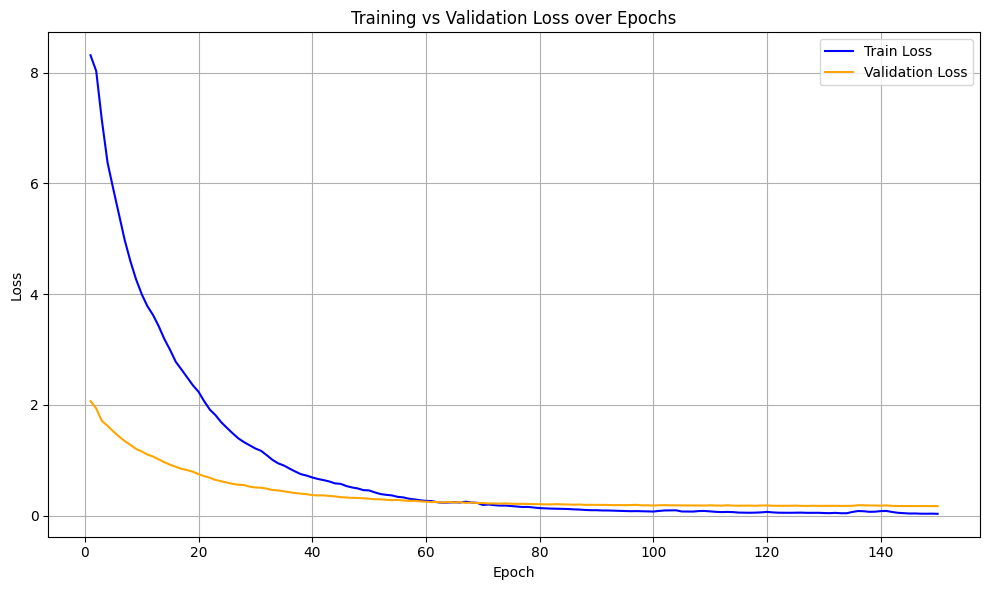

In [44]:
# Plotting training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
# Testing
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_loader:
        u = batch[0]
        _, recon = model(u)
        loss = criterion(recon, u)
        test_loss += loss.item()

print(f"Final Test Loss: {test_loss:.4f}")

Final Test Loss: 0.3180


In [46]:
# Saving the model
torch.save(model.state_dict(), 'autoencoder_model.pth')

In [47]:
# Loading the model
model = user_AE(input_dim=input_dim, emb_size=100)

model.load_state_dict(torch.load('autoencoder_model.pth'))
model.eval()


user_AE(
  (encoder): Sequential(
    (0): Linear(in_features=49, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=49, bias=True)
  )
)

In [48]:
# def proc_col(col, train_col=None):
#     """Encodes a pandas column with continuous ids.
#     """
#     if train_col is not None:
#         uniq = train_col.unique()
#     else:
#         uniq = col.unique()
#     name2idx = {o:i for i,o in enumerate(uniq)}
#     return name2idx, np.array([name2idx.get(x, -1) for x in col]), len(uniq)


# def encode_data(df, train=None):
#     """ Encodes rating data with continous user and movie ids.
#     If train is provided, encodes df with the same encoding as train.
#     """
#     df = df.copy()
#     n2id = []
#     for col_name in ["iid", "pid"]:
#         train_col = None
#         if train is not None:
#             train_col = train[col_name]
#         name2idx,col,_ = proc_col(df[col_name], train_col)
#         df[col_name] = col
#         df = df[df[col_name] >= 0]
#         n2id.append(name2idx)
#     return df, n2id

In [49]:
# df_train, n2id = encode_data(train)
# df_val, _ = encode_data(test, train)

In [50]:
# torch.LongTensor(train.iid.values)

In [51]:
# torch.LongTensor(df_train.iid.values)

In [52]:
# users = torch.LongTensor(df_train.iid.values)
# items = torch.LongTensor(df_train.pid.values)
# ratings = torch.FloatTensor(df_train.match.values)

In [53]:
# num_users = len(users.unique())
# num_items = len(items.unique())
# print(num_users, num_items)

# Collaborative Filtering Training

In [54]:
class MF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100):
        super(MF, self).__init__()
        self.emb_size = emb_size
        self.hidden_size = 0
        self.user_emb = nn.Embedding(num_users, emb_size) #user_AE
        self.item_emb = nn.Embedding(num_items, emb_size) #item_AE
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)

    def forward(self, u, v):
        u = self.user_emb(u)
        v = self.item_emb(v)
        return (u*v).sum(1)


In [55]:
data_for_collaborative_filtering

,iid,pid,match
0,1,11.0,0
1,1,12.0,0
2,1,13.0,1
3,1,14.0,1
4,1,15.0,1
...,...,...,...
8373,552,526.0,0
8374,552,527.0,0
8375,552,528.0,0
8376,552,529.0,0


In [56]:
# unique_users = df['iid'].unique()
# unique_items = df['pid'].unique()

# all_combinations = pd.MultiIndex.from_product([unique_users, unique_items], names=['iid', 'pid'])
# df_full = df.set_index(['iid', 'pid']).reindex(all_combinations, fill_value=0).reset_index()

# df = df_full.copy()

# df.head(50)
# # There's iid 0 (isn't supposed to be?), Maybe need to remove

In [57]:
from sklearn.preprocessing import LabelEncoder

user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

data_for_collaborative_filtering['iid'] = user_encoder.fit_transform(data_for_collaborative_filtering['iid'])
data_for_collaborative_filtering['pid'] = product_encoder.fit_transform(data_for_collaborative_filtering['pid'])

user_ids = torch.tensor(data_for_collaborative_filtering['iid'].to_numpy(), dtype=torch.long)
item_ids = torch.tensor(data_for_collaborative_filtering['pid'].to_numpy(), dtype=torch.long)
interactions = torch.tensor(data_for_collaborative_filtering['match'].to_numpy(), dtype=torch.float32)

train_user_ids, test_user_ids, train_item_ids, test_item_ids, train_interactions, test_interactions = train_test_split(
    user_ids, item_ids, interactions, test_size=0.2, random_state=42
)
train_user_ids, val_user_ids, train_item_ids, val_item_ids, train_interactions, val_interactions = train_test_split(
    train_user_ids, train_item_ids, train_interactions, test_size=0.2, random_state=42
)

<ipython-input-57-238a16368b0d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_collaborative_filtering['iid'] = user_encoder.fit_transform(data_for_collaborative_filtering['iid'])
<ipython-input-57-238a16368b0d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_collaborative_filtering['pid'] = product_encoder.fit_transform(data_for_collaborative_filtering['pid'])


In [58]:
class CollaborativeFilteringDataset(Dataset):
    def __init__(self, user_ids, item_ids, interactions):
        self.user_ids = user_ids
        self.item_ids = item_ids
        self.interactions = interactions

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        return self.user_ids[idx], self.item_ids[idx], self.interactions[idx]

In [59]:
train_dataset = CollaborativeFilteringDataset(train_user_ids, train_item_ids, train_interactions)
val_dataset = CollaborativeFilteringDataset(val_user_ids, val_item_ids, val_interactions)
test_dataset = CollaborativeFilteringDataset(test_user_ids, test_item_ids, test_interactions)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [60]:
embedding_dim = 10
num_users = len(user_encoder.classes_)
num_items = len(product_encoder.classes_)
model = MF(num_users, num_items, emb_size=embedding_dim)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [61]:
# Training loop with validation and plotting
num_epochs = 25
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for user, item, interaction in train_loader:
        optimizer.zero_grad()
        predictions = model(user, item)
        loss = criterion(predictions, interaction)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for user, item, interaction in val_loader:
            predictions = model(user, item)
            loss = criterion(predictions, interaction)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Evaluate on the test set
model.eval()
test_loss = 0
with torch.no_grad():
    for user, item, interaction in test_loader:
        predictions = model(user, item)
        loss = criterion(predictions, interaction)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/25, Train Loss: 0.6942, Val Loss: 0.6935
Epoch 2/25, Train Loss: 0.6929, Val Loss: 0.6931
Epoch 3/25, Train Loss: 0.6917, Val Loss: 0.6920
Epoch 4/25, Train Loss: 0.6879, Val Loss: 0.6882
Epoch 5/25, Train Loss: 0.6785, Val Loss: 0.6792
Epoch 6/25, Train Loss: 0.6614, Val Loss: 0.6643
Epoch 7/25, Train Loss: 0.6369, Val Loss: 0.6444
Epoch 8/25, Train Loss: 0.6067, Val Loss: 0.6216
Epoch 9/25, Train Loss: 0.5733, Val Loss: 0.5974
Epoch 10/25, Train Loss: 0.5392, Val Loss: 0.5738
Epoch 11/25, Train Loss: 0.5060, Val Loss: 0.5514
Epoch 12/25, Train Loss: 0.4743, Val Loss: 0.5314
Epoch 13/25, Train Loss: 0.4457, Val Loss: 0.5134
Epoch 14/25, Train Loss: 0.4199, Val Loss: 0.4986
Epoch 15/25, Train Loss: 0.3967, Val Loss: 0.4856
Epoch 16/25, Train Loss: 0.3766, Val Loss: 0.4751
Epoch 17/25, Train Loss: 0.3586, Val Loss: 0.4664
Epoch 18/25, Train Loss: 0.3428, Val Loss: 0.4588
Epoch 19/25, Train Loss: 0.3287, Val Loss: 0.4531
Epoch 20/25, Train Loss: 0.3157, Val Loss: 0.4486
Epoch 21/

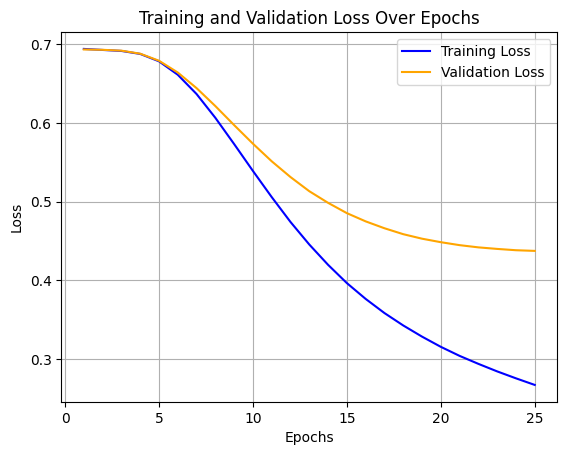

In [62]:
# Plotting the loss curves
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [63]:
# Example prediction after training
user_idx = torch.tensor([1])  # Example: User index
item_idx = torch.tensor([11])  # Example: Item index (Partner)
prediction = model(user_idx, item_idx)
predicted_interaction = torch.sigmoid(prediction).item()

print(f"Predicted interaction score for user {user_idx.item()} and user {item_idx.item()}: {predicted_interaction}")

Predicted interaction score for user 1 and user 11: 0.2689194679260254


In [64]:
# Saving the model
torch.save(model.state_dict(), "collaborative_filtering_model.pth")
print("Model saved successfully.")

Model saved successfully.


In [65]:
# Load the saved model
model = MF(num_users, num_items, emb_size=embedding_dim)
model.load_state_dict(torch.load("collaborative_filtering_model.pth"))
model.eval()

MF(
  (user_emb): Embedding(551, 10)
  (item_emb): Embedding(551, 10)
)

In [66]:
# def evaluate(model, df):
#     model.eval()
#     users = torch.LongTensor(df.iid.values)
#     items = torch.LongTensor(df.pid.values)
#     ratings = torch.FloatTensor(df.match.values)
#     y_pred = model(users, items)
#     loss = F.mse_loss(y_pred,ratings)
#     return loss.item()
# def plot_loss(train_loss_record, val_loss_record):
#     epochs = range(1, len(train_loss_record) + 1)

#     plt.figure(figsize=(10, 6))

#     plt.plot(epochs, train_loss_record, label='Training Loss', color='blue', marker='o')

#     plt.plot(epochs, val_loss_record, label='Validation Loss', color='red', marker='x')

#     plt.title('Training and Validation Loss over Epochs')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')

#     plt.legend()

#     plt.grid(True)
#     plt.show()
# def get_model_path(model, epoch, lr, wd):
#     model_path = f"model_emb{model.emb_size}_hid{model.hidden_size}_lr{lr}_wd{wd}_epoch{epoch}"
#     return model_path
# def train(model, num_epochs=10, lr = 0.01, wd = 0.0, print_loss=True, binary = False):
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
#     model.train()

#     train_loss_record = []
#     val_loss_record = []
#     for i in range(num_epochs):
#         y_pred = model(users, items)
#         loss = F.mse_loss(y_pred, ratings)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         val_loss = evaluate(model, df_val)

#         if print_loss == True:
#             print(f"Epoch {i}, Training Loss: {loss.item():.3f}")
#             print(f"Epoch {i}, Validation Loss: {val_loss:.3f}")
#         train_loss_record.append(loss.item())
#         val_loss_record.append(val_loss)
#         model_path = get_model_path(model, i, lr, wd)
#         torch.save(model.state_dict(), model_path)
#     return train_loss_record, val_loss_record


In [67]:
# model = MF(num_users, num_items, emb_size = 20)
# train_loss_record, val_loss_record = train(model, lr = 0.0005, num_epochs=300, print_loss=True)

In [68]:
# plot_loss(train_loss_record, val_loss_record)

# Evaluation